# Import libraries

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.classifier.logistic import logistic_classifier
from dirrac.optim.opt import Optimization
from roar.gen_counterfactual import ROAR
from dirrac.gen_counterfactual import DRRA
from utils import cal_validity

In [2]:
if not os.path.exists('result/figure9/'):
    os.makedirs('result/figure9/')

# Synthesize data and train original classifier

In [3]:
# Synthesize data
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000
p = [0.4, 0.2, 0.4]

sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.4, 0.2, 0.4], [0.1, 0.1])

In [4]:
# Train
all_coef = np.zeros((101, 2))
for i in range(101):
    coef = logistic_classifier(features[i], labels[i])[1].T
    all_coef[i] = np.squeeze(coef)

# Get theta
mean_shift = all_coef[1:41]
cov_shift = all_coef[41:61]
both_shift = all_coef[61:101]

theta = np.zeros((3, 2))
sigma = np.zeros((3, 2, 2))

theta[0], sigma[0] = np.mean(mean_shift, axis=0), np.cov(mean_shift.T)
theta[1], sigma[1] = np.mean(cov_shift, axis=0), np.cov(cov_shift.T)
theta[2], sigma[2] = np.mean(both_shift, axis=0), np.cov(both_shift.T)

In [5]:
# Train a classifier
X_train, X_test, y_train, y_test = train_test_split(features[0], labels[0], test_size=0.1, random_state=42)

# Train and get theta
clf, coef = logistic_classifier(X_train, y_train)

yhat = clf.predict(X_test)
X_recourse = X_test[yhat == 0]

# Define function

In [98]:
# Optimization module
delta_l = [1e-3, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
k = 3
dim = 2
rho = np.array([0, 0, 0])
lmbda = 0.7
zeta = 1

features_shift, labels_shift = sd.synthesize_modes_data(1000, [0.1, 0.8, 0.1], [0.2, 0.2])
clf_shift = [logistic_classifier(features_shift[i + 1], labels_shift[i + 1])[0] for i in range(len(features_shift) - 1)]

def recourse_cost(X_recourse):
    
    cost_dirrac, cost_roar = [], []
    val_dirrac, val_roar = [], []
    
    # delta_l = [1e-3, 7e-3, 8e-3, 0.05, 0.1]
    delta_l = [1e-3, 0.1, 0.5, 1.5, 2.5]
    dirrac_l = [DRRA(delta_l[i], k, dim, p, theta, sigma, rho, lmbda, zeta, dist_type='l1') for i in range(len(delta_l))]
    
    iter_l = [10, 15, 16, 17, 20]
    roar_l = [ROAR(X_recourse, all_coef[0], np.zeros(1), 1e-3, 0.1, sigma_max=0.1, alpha=2, dist_type='l1', max_iter=iter_l[i]) for i in range(len(iter_l))]
    
    for i in range(len(delta_l)):
        all_val_dirrac = np.zeros(len(features_shift) - 1)
        all_val_roar = np.zeros(len(features_shift) - 1)
        
        x_drra = dirrac_l[i].fit_data(X_recourse)
        x_roar = roar_l[i].fit_data(roar_l[i].data)[:, :-1]
        
        l1 = np.mean(np.linalg.norm((x_drra - X_recourse), ord=1, axis=1))
        l2 = np.mean(np.linalg.norm((x_roar - X_recourse), ord=1, axis=1))

        cost_dirrac.append(l1)
        cost_roar.append(l2)
    
        for j in range(len(features_shift) - 1):
            # Train and get theta
            all_val_dirrac[j] = np.mean(clf_shift[j].predict(x_drra))
            all_val_roar[j] = np.mean(clf_shift[j].predict(x_roar))
        
        val_dirrac.append(np.mean(all_val_dirrac))
        val_roar.append(np.mean(all_val_roar))
    
    return cost_dirrac, val_dirrac, cost_roar, val_roar

In [99]:
cost_dirrac, val_dirrac, cost_roar, val_roar = recourse_cost(X_recourse[:2])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 30.51it/s]


tensor(-3.7922, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-3.4320, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.9144, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.0639, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-0.3324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.4744, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5397, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5966, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6468, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6918, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.2557, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.1822, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.1024, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.0150, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-4.9187, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-4.8114, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-4.6907, dtype=torch.float64, grad_fn=

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.99it/s]


tensor(-3.7922, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-3.4320, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.9144, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.0639, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-0.3324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.4744, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5397, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5966, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6468, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6918, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7695, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8034, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8348, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8640, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.2557, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.1822, dtype=torch.float64, grad_fn=<DotB

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.00it/s]


tensor(-3.7922, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-3.4320, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.9144, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.0639, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-0.3324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.4744, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5397, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5966, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6468, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6918, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7695, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8034, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8348, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8640, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8911, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-5.2557, dtype=torch.float64, grad_fn=<DotBa

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.50it/s]


tensor(-3.7922, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-3.4320, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.9144, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.0639, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-0.3324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.4744, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5397, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5966, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6468, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6918, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7695, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8034, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8348, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8640, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8911, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.9165, dtype=torch.float64, grad_fn=<DotBac

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.97it/s]


tensor(-3.7922, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-3.4320, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.9144, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-2.0639, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(-0.3324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.4744, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5397, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.5966, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6468, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.6918, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7324, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.7695, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8034, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8348, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8640, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.8911, dtype=torch.float64, grad_fn=<DotBackward>)
tensor(2.9165, dtype=torch.float64, grad_fn=<DotBac

In [100]:
cost_dirrac, val_dirrac, cost_roar, val_roar

([3.2760493538067528,
  3.375049353806753,
  3.775049353806753,
  4.178941202268796,
  4.178752266026505],
 [0.597, 1.0, 1.0, 1.0, 1.0],
 [2.546068553317239,
  3.4306475976619635,
  4.17130431197972,
  4.63420261867716,
  4.775320064324818],
 [0.5, 0.5, 0.757, 0.968, 0.989])

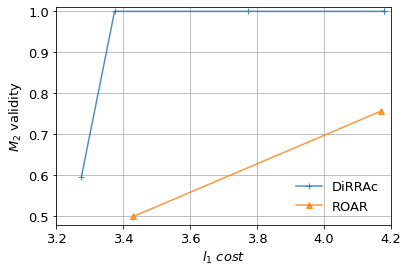

In [112]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
ax.plot(cost_dirrac, val_dirrac, marker='+',label='DiRRAc', alpha=0.8)
ax.plot(cost_roar[1:3], val_roar[1:3], marker='^', label='ROAR', alpha=0.8)

ax.set(xlabel='$l_{1}\ cost$', ylabel='$M_{2}$ validity')
ax.grid()
ax.legend(loc='lower right', frameon=False)
ax.set_xlim([3.2, 4.2])
ax.set_ylim([0.48, 1.01])

plt.savefig('result/figure9/cost_robust_dirrac_roar.pdf', dpi=400, transparent=True)
plt.show()